# Import package and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
DATA_PATH = "../data/"
data = pd.read_csv(DATA_PATH+"2016_Building_Energy_Benchmarking.csv", sep=",", encoding="iso-8859-1")

# Phase 1

## Cleaning

In [3]:
pd.set_option('display.max_info_rows',50)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   OSEBuildingID                    int64  
 1   DataYear                         int64  
 2   BuildingType                     object 
 3   PrimaryPropertyType              object 
 4   PropertyName                     object 
 5   Address                          object 
 6   City                             object 
 7   State                            object 
 8   ZipCode                          float64
 9   TaxParcelIdentificationNumber    object 
 10  CouncilDistrictCode              int64  
 11  Neighborhood                     object 
 12  Latitude                         float64
 13  Longitude                        float64
 14  YearBuilt                        int64  
 15  NumberofBuildings                float64
 16  NumberofFloors                   int64  
 17  PropertyGFATot

In [4]:
data.isna().mean()[data.isna().mean() > 0.10]

SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
YearsENERGYSTARCertified           0.964751
ENERGYSTARScore                    0.249704
Comments                           1.000000
Outlier                            0.990521
dtype: float64

In [5]:
label_1 = "SiteEnergyUse(kBtu)"
label_2 = "TotalGHGEmissions"

In [6]:
all_columns = list(data.columns)
categorical_columns = ["BuildingType", "PrimaryPropertyType","PropertyName","City","State","Address","City","State",
                       "ZipCode","CouncilDistrictCode","Neighborhood","ListOfAllPropertyUseTypes",
                       "LargestPropertyUseType","SecondLargestPropertyUseType","ThirdLargestPropertyUseType","ComplianceStatus"]
numerical_columns = [column for column in all_columns if column not in categorical_columns]

In [7]:
# Premier nettoyage du dataframe
def clean_data(df, to_drop):
    print("--------- shape before cleaning ---------")
    print(df.shape)
    df = df[df.ComplianceStatus == "Compliant"]
    df.Outlier.fillna('not_outlier', inplace=True)
    df.SecondLargestPropertyUseType.fillna('one_use', inplace=True)
    df.ThirdLargestPropertyUseType.fillna('one_use', inplace=True)
    df = df[df.NumberofBuildings != 0]
    df = df[df.NumberofFloors != 0]
    df = df[df['DefaultData'] == False]
    df.loc[df['SecondLargestPropertyUseType'] == 'one_use', 'SecondLargestPropertyUseTypeGFA'] = 0
    df.loc[df['ThirdLargestPropertyUseType'] == 'one_use', 'ThirdLargestPropertyUseTypeGFA'] = 0
    df['Nb_PropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.count(',') + 1
    df["Building_age"] = df["DataYear"] - df["YearBuilt"]
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna(df['PrimaryPropertyType'])
    df['LargestPropertyUseTypeGFA'] = df['LargestPropertyUseTypeGFA'].fillna(df['PropertyGFATotal'])
    df["%_LargestPropertyUseType"] = df["LargestPropertyUseTypeGFA"] / df["PropertyGFATotal"]    
    for col in to_drop:
        if col in df.columns:
            df = df.drop(columns=[col])
    print("--------- shape before cleaning ---------")
    print(df.shape)
    return df

# Mise à jour des listes des colonnes
def update_columns_list(list_1, dropped):
    new_list = [col for col in list_1 if col not in dropped]
    return new_list

In [8]:
# Vérifier la GFA
data["GFATotal"] = data["PropertyGFAParking"] + data["PropertyGFABuilding(s)"]
check_GPA = pd.Series(data["GFATotal"] == data["PropertyGFATotal"])
data.drop(columns=["GFATotal"], inplace=True)
check_GPA.value_counts()

True    3376
dtype: int64

In [9]:
data = data[~data.BuildingType.isin(["Multifamily LR (1-4)","Multifamily MR (5-9)","Multifamily HR (10+)"])]
data["%_GFAParking"] = data["PropertyGFAParking"] / data["PropertyGFATotal"]
data["%_GFABuilding"] = data["PropertyGFABuilding(s)"] / data["PropertyGFATotal"]


In [10]:
columns_to_drop = ["DataYear","PropertyName","Address","City","State",
                "Latitude","Longitude","YearBuilt","TaxParcelIdentificationNumber",
                "YearsENERGYSTARCertified","Comments","DefaultData","ComplianceStatus",
                "SiteEnergyUseWN(kBtu)","PropertyGFAParking","PropertyGFABuilding(s)","ListOfAllPropertyUseTypes"]

In [11]:
data = clean_data(data, columns_to_drop)
categorical_columns = update_columns_list(categorical_columns,columns_to_drop)

--------- shape before cleaning ---------
(1668, 48)
--------- shape before cleaning ---------
(1481, 34)


/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [12]:
data.BuildingType.value_counts()

NonResidential        1375
Nonresidential COS      73
Campus                  22
SPS-District K-12       10
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [13]:
pd.set_option('display.max_columns',50)
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,%_GFAParking,%_GFABuilding,Nb_PropertyUseTypes,Building_age,%_LargestPropertyUseType
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,12,88434,Hotel,88434.0,one_use,0.0,one_use,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,not_outlier,249.98,2.83,0.000000,1.000000,1,89,1.000000
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,not_outlier,295.86,2.86,0.145453,0.854547,3,20,0.809918
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,41,956110,Hotel,756493.0,one_use,0.0,one_use,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,not_outlier,2089.28,2.19,0.205748,0.794252,1,47,0.791220
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,10,61320,Hotel,61320.0,one_use,0.0,one_use,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,not_outlier,286.43,4.67,0.000000,1.000000,1,90,1.000000
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,1.0,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,not_outlier,505.01,2.88,0.353115,0.646885,3,36,0.703070


In [14]:
data.ENERGYSTARScore = data.ENERGYSTARScore.fillna('no_score')
data = data[data["ENERGYSTARScore"] != 'no_score']

## Exploration label

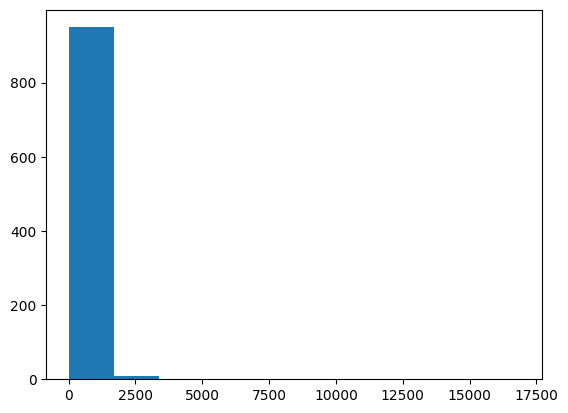

In [15]:
plt.hist(data["TotalGHGEmissions"]);

In [16]:
data["TotalGHGEmissions"].describe()

count      964.000000
mean       193.268672
std        873.974092
min         -0.800000
25%         20.165000
50%         49.215000
75%        140.090000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

In [17]:
data["TotalGHGEmissions"].quantile([0, .5, 0.98])

0.00      -0.8000
0.50      49.2150
0.98    1008.6684
Name: TotalGHGEmissions, dtype: float64

In [18]:
data = data[data["TotalGHGEmissions"] <= data["TotalGHGEmissions"].quantile([0.98])[0.98]]
data = data[data["TotalGHGEmissions"] > 0]

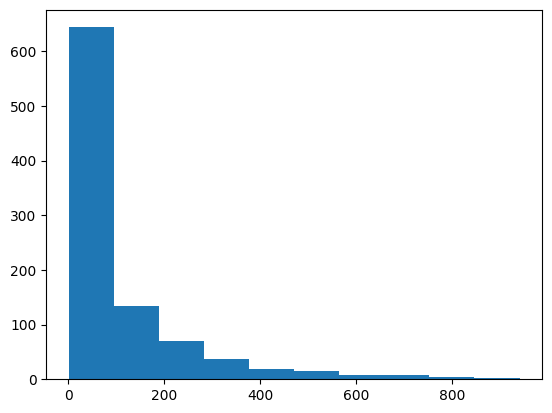

In [19]:
plt.hist(data[label_2]);

In [20]:
data[label_1].describe()

count    9.420000e+02
mean     6.206883e+06
std      9.461551e+06
min      7.971180e+04
25%      1.236609e+06
50%      2.687720e+06
75%      7.033444e+06
max      9.293764e+07
Name: SiteEnergyUse(kBtu), dtype: float64

In [21]:
data[label_2].describe()

count    942.000000
mean     106.159830
std      145.085844
min        0.810000
25%       19.937500
50%       47.975000
75%      130.575000
max      940.470000
Name: TotalGHGEmissions, dtype: float64

# Choix des features

In [32]:
features = ['BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'Neighborhood',  'Building_age','NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA',  '%_LargestPropertyUseType',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)',
       'TotalGHGEmissions','SourceEUI(kBtu/sf)',
       '%_GFAParking', '%_GFABuilding','Nb_PropertyUseTypes']

In [33]:
categorical_columns = update_columns_list(categorical_columns,columns_to_drop)
numerical_columns = update_columns_list(numerical_columns,columns_to_drop)

In [34]:
df = data[features]
cat_features = [col for col in features if col in categorical_columns]
num_features = [col for col in features if col in categorical_columns]

In [29]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'ZipCode', 'Neighborhood',
       'Building_age', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', '%_LargestPropertyUseType',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', '%_GFAParking',
       '%_GFABuilding', 'Nb_PropertyUseTypes'],
      dtype='object')

## Categorical features

In [35]:
df.BuildingType.nunique(), df.PrimaryPropertyType.nunique(), df.ZipCode.nunique(), df.Neighborhood.nunique(), df.LargestPropertyUseType.nunique()

(4, 16, 38, 18, 19)

In [36]:
def pipe_ohe(df):
    
    #### encoder la colonne LargestPropertyUseType ###
    # Ajouter les colonnes encodées au dataframe d'origine
    # Supprimer la colonne originale
    onehot_encoded = pd.get_dummies(df['LargestPropertyUseType'], prefix='LargestPropertyUseType')
    df = pd.concat([df, onehot_encoded], axis=1)
    df.drop('LargestPropertyUseType', axis=1, inplace=True)
    
    #### encoder la colonne BuildingType ###
    # Ajouter les colonnes encodées au dataframe d'origine
    # Supprimer la colonne originale
    onehot_encoded_BuildingType = pd.get_dummies(df['BuildingType'], prefix='BuildingType')
    df = pd.concat([df, onehot_encoded_BuildingType], axis=1)
    df.drop('BuildingType', axis=1, inplace=True)
    
    ### Remplacer les valeurs 1/0 de LargestPropertyUseType_ par leur % de la surface totale
    # Liste des colonnes à remplacer
    # Boucle pour remplacer les valeurs dans chaque colonne
    cols_to_replace = list(df.filter(like="LargestPropertyUseType_").columns)
    for col in cols_to_replace:
        df[col] = df.apply(lambda row: row["%_LargestPropertyUseType"] if row[col] == 1 else 0, axis=1)    
    df.drop(columns=["%_LargestPropertyUseType"], inplace=True)
    
    return df

In [37]:
def pipe(df, means_zipcode=None, 
                means_neighborhood=None,
                means_ppropertype=None, 
                col_for_mean="PropertyGFATotal", 
                scaler=None,
                label_1=label_1,
                label_2=label_2):
    #### encoder la colonne ZipCode ###
    # encoding ZipCode with mean encoding and TotalGHGEmissions #
    # Calculer la moyenne de la colonne cible (label2) pour chaque code postal
    # Encoder la colonne code postal en fonction de la moyenne de la colonne cible
    # Supprimer la colonne originale
    mean_encoding_nan = df[col_for_mean].mean()
    if means_zipcode is None:
        means_zipcode = df.groupby('ZipCode')[col_for_mean].mean()
    df['Code_postal_encoded'] = df['ZipCode'].map(means_zipcode)
    df['Code_postal_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    ### encoder la colonne Neighborhood ###
    # Calculer la moyenne de la colonne cible (label2) pour chaque quartier
    # Encoder la colonne quartier en fonction de la moyenne de la colonne cible
    # Supprimer la colonne originale
    if means_neighborhood is None:
        means_neighborhood = df.groupby('Neighborhood')[col_for_mean].mean()
    df['neighborhood_encoded'] = df['Neighborhood'].map(means_neighborhood)
    df.drop(columns=['Neighborhood'],inplace=True)
    df['neighborhood_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    
    ### encoder la colonne PrimaryPropertyType with mean encoding  ###
    # Calculer la moyenne de la colonne cible (label2) pour chaque PrimaryPropertyType
    # Encoder la colonne PrimaryPropertyType en fonction de la moyenne de la colonne cible
    # Supprimer la colonne catégorielle
    if means_ppropertype is None:
        means_ppropertype = df.groupby('PrimaryPropertyType')[col_for_mean].mean()
    df['PrimaryPropertyType_encoded'] = df['PrimaryPropertyType'].map(means_ppropertype)
    df.drop(columns=['PrimaryPropertyType'],inplace=True)
    df['PrimaryPropertyType_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    #supprimer les labels du jeu de données
    df = df.drop(columns=[label_1,label_2])
    df.drop(columns=['SourceEUI(kBtu/sf)', 'SteamUse(kBtu)','Electricity(kBtu)', 'NaturalGas(kBtu)'], inplace=True)
    
    #scaler
    # if scaler is None:
    #     scaler=StandardScaler()
    #     df_scaled = scaler.fit_transform(df)
    #     print("check scaler standard scaler")
    # else:
    #     df_scaled = scaler.transform(df)
    #     print("check scaler the train scaler")
    
    return df, means_zipcode, means_neighborhood, means_ppropertype, df.columns

In [38]:
X = pipe_ohe(df)
y1 = df[[label_1]]
y2 = df[[label_2]]

X_enrg_train, X_enrg_test, y_nrg_train, y_nrg_test = train_test_split(X,y1,test_size=0.15, random_state=42, stratify=df["BuildingType"])
print(X_enrg_train.shape, X_enrg_test.shape)

# séparer la donnée pour avoir les 
X_ghge_train, X_ghge_test, y_ghe_train, y_ghe_test = train_test_split(X,y2,test_size=0.15, random_state=42, stratify=df["BuildingType"])
print(X_ghge_train.shape, X_ghge_test.shape)

index_X_enrg_test = X_enrg_test.index
df_nrg_selection = df.loc[index_X_enrg_test]

index_X_ghge_test = X_ghge_test.index
df_ghe_selection = df.loc[index_X_ghge_test]

X_nrg_train, means_zipcode_enrg, means_neighborhood_enrg, means_ppropertype_enrg, columns_enrg = pipe(X_enrg_train,col_for_mean=label_1)
X_nrg_test, means_zipcode_enrg, means_neighborhood_enrg, means_ppropertype_enrg, a = pipe(X_enrg_test,
                                                                        means_zipcode=means_zipcode_enrg,
                                                                        means_neighborhood=means_neighborhood_enrg,
                                                                        means_ppropertype=means_ppropertype_enrg,
                                                                        col_for_mean=label_1)

X_ghe_train, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, columns_ghe = pipe(X_ghge_train,col_for_mean=label_2)
X_ghe_test, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, b = pipe(X_ghge_test, 
                                                                        means_zipcode=means_zipcode_ghe,
                                                                        means_neighborhood=means_neighborhood_ghe,
                                                                        means_ppropertype=means_ppropertype_ghe,
                                                                        col_for_mean=label_2)

print(X_nrg_train.shape, X_nrg_test.shape), 
print(X_ghe_train.shape, X_ghe_test.shape)

(800, 40) (142, 40)
(800, 40) (142, 40)
(800, 35) (142, 35)
(800, 35) (142, 35)


## Modèles

###  Results functions

In [39]:
def results_printed(model):
    # Best score                     
    print(f"Best score : {model.best_score_}")
    
    # Best Params
    print(f"Best params :\n {model.best_params_}")

In [40]:
metrics_df_nrg = pd.DataFrame(columns=["label","modèle","r2_train","r2_test","mae","rmse","mean_fit_time","best_params"])
metrics_df_ghe = pd.DataFrame(columns=["label","modèle","r2_train","r2_test","mae","rmse","mean_fit_time","best_params"])

def add_metrics_table(label,y_pred,y_test,df,model, X_train, y_train):
    # Accéder au nom du modèle
    best_model = model.best_estimator_
    model_name = best_model.steps[1][0]
    
    r2_train = round(model.score(X_train, y_train,),4)
    r2_test = round(r2_score(y_test, y_pred), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    rmse = round(mean_squared_error(y_test, y_pred), 4)
    df = df.append({
    "label": label,
    "modèle": model_name,
    "r2_train":'{:.3f}'.format(r2_train),
    "r2_test": '{:.3f}'.format(r2_test),
    "mae": '{:.3f}'.format(mae),
    "rmse": '{:.3f}'.format(rmse),
    "mean_fit_time": model.cv_results_['mean_fit_time'].mean(),
    "best_params": model.best_params_
    }, ignore_index=True)
    return df

scoring = ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"]

def evaluate_prediction(label, X_test, y_test, metrics_df, model, X_train, y_train):
    y_pred = model.predict(X_test)

    metrics_df = add_metrics_table(label, y_pred, y_test, metrics_df, model, X_train, y_train)

    # Créer le scatter plot
    plt.scatter(y_pred, y_test)

    # Ajouter une ligne diagonale pour représenter la ligne de prédiction parfaite
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

    # Ajouter des labels pour les axes et le titre du plot
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title('Comparaison des prédictions et des valeurs réelles')

    # Afficher le plot
    plt.show()
    display(metrics_df)
    return metrics_df, y_pred

In [41]:
def hist_errors(y_test, y_pred):
    y_test = np.array(y_test).reshape(-1,)
    diff = y_test - y_pred
    mean = diff.mean()
    std = diff.std()
    plt.hist(diff, bins=40)
    plt.vlines(mean, 0, 30, color='red', label=f'mean = {mean:.2f}')
    plt.hlines(30, mean - 1/2 * std, mean + 1/2 * std, color='red', label=f'std = {std:.2f}', ls='dotted')
    plt.title('Histogram of prediction errors')
    plt.xlabel('prediction error')
    plt.ylabel('Frequency')
    
    # Showing the legend
    plt.legend(loc='upper right')
    plt.show()

In [42]:
def show_fetures_coef(model, columns):
    
    # Après l'exécution de la recherche de grille
    best_model = model.best_estimator_

    # Accéder au nom du modèle
    model_name = best_model.steps[1][0]
    
    # Accéder aux coefficients du modèle
    coef = best_model.named_steps[model_name].coef_

    if coef.ndim == 2 and coef.shape[0] == 1:
        coef = coef[0]
    features_coef = pd.DataFrame(coef.reshape(1,-1), columns=list(columns))
    columns = list(reversed(features_coef.columns))
    coef = list(reversed(coef))
    
    
    plt.figure(figsize=(14,8))
    # Créer un graphique à barres horizontales
    plt.barh(columns, coef)

    # Récupérer les étiquettes de l'axe des abscisses
    labels = plt.gca().get_yticklabels()

    # Parcourir les étiquettes et appliquer un style différent aux étiquettes non nulles
    for label, value in zip(labels, coef):
        if value != -0:
            label.set_color('red')  # Appliquer une couleur rouge aux étiquettes non nulles
        else:
            label.set_color('black')  # Appliquer une couleur noire aux étiquettes nulles

    plt.show()

In [43]:
def error_per_category(df, y_test, y_pred, feature):
    df["error_pred"] = (np.array(y_test).reshape(-1,) - y_pred)
    df_grouped = df.groupby(feature).mean()['error_pred']
    counts = df[feature].value_counts()

    # Créer le graphique montrant la moyenne des erreurs et le nombre d'occurrences
    fig, ax = plt.subplots()

    # Afficher les barres de la moyenne des erreurs
    ax.bar(df_grouped.index, df_grouped.values)

    # Ajouter le nombre d'occurrences sur les barres de la moyenne des erreurs
    for i, v in enumerate(df_grouped.values):
        ax.text(i, v, str(counts[df_grouped.index[i]]), ha='center', va='bottom')

    # Ajouter une légende
    ax.text(0.05, -0.2, f'{counts[df_grouped.index[i]]}:Nombre d\'occurrences dans le jeu de test', transform=ax.transAxes)

    ax.set_xlabel(feature)
    ax.set_ylabel('Moyenne des erreurs')

    # Changer la taille de la figure
    fig.set_size_inches(8, 4)
    
    # Ajouter un espace supplémentaire de 10% au-dessus et en dessous des barres du graphique
    ax.margins(y=0.1)
    
    plt.show()

In [44]:
def error_all_category(df, y_test, y_pred, features):
    # Créer une figure avec des subplots
    fig, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 4 * len(features)), gridspec_kw={'hspace': 0.6})
    axs[0].set_ylabel('Moyenne des erreurs')

    # Boucle sur les features
    for i, feature in enumerate(features):
        # Récupérer l'axe courant
        ax = axs[i]

        # Calculer les erreurs moyennes pour chaque catégorie
        df["error_pred"] = abs((np.array(y_test).reshape(-1,) - y_pred))
        df_grouped = df.groupby(feature).mean()['error_pred']
        counts = df_nrg_selection[feature].value_counts()

        # Afficher les barres de la moyenne des erreurs
        ax.bar(df_grouped.index, df_grouped.values)

        # Ajouter le nombre d'occurrences sur les barres de la moyenne des erreurs
        for i, v in enumerate(df_grouped.values):
            ax.text(i, v, str(counts[df_grouped.index[i]]), ha='center', va='bottom')

        # Ajouter un titre pour chaque subplot
        ax.set_title(feature)

        # Ajouter un espace supplémentaire de 10% au-dessus et en dessous des barres du graphique
        ax.margins(y=0.1)
        
        # Ajouter des étiquettes d'axe plus petites et penchées
        ax.set_xticklabels(df_grouped.index, rotation=45, fontsize=7)

    # Ajouter un titre pour le graphique global
    fig.suptitle('Erreurs en fonction des variables catégorielles', y=0.95, fontsize=16)

    # Afficher le graphique
    plt.show()


In [45]:
def error_discrete_feature(df, col):
    # Créer un graphique en nuage de points pour représenter les erreurs
    fig, ax = plt.subplots()
    ax.scatter(df[col], df['error_pred'], label=col)

    # Ajouter les labels des axes et la légende
    ax.set_xlabel(col)
    ax.set_ylabel('error_pred')

    plt.show()

In [46]:
def error_all_discr_category(df, y_test, y_pred, features):
    # Créer une figure avec des subplots
    fig, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 4 * len(features)), gridspec_kw={'hspace': 0.3})

    # Calculer les erreurs moyennes pour chaque catégorie
    df["error_pred"] = abs((np.array(y_test).reshape(-1,) - y_pred))
        
    # Boucle sur les features
    for i, feature in enumerate(features):
        # Récupérer l'axe courant
        ax = axs[i]

        ax.scatter(df[feature], df['error_pred'], label=feature)

        # Ajouter un titre pour chaque subplot
        ax.set_title(feature)

    # Ajouter un titre pour le graphique global
    fig.suptitle('Erreurs en fonction des variables discrètes', y=0.92, fontsize=16)

    # Afficher le graphique
    plt.show()


### Pipeline with a scaler

In [47]:
# Définir les normalizers à tester
scalers = [
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('MaxAbsScaler', MaxAbsScaler())
]

In [48]:
cat_features_next = ['BuildingType',
'PrimaryPropertyType',
'Neighborhood',
'LargestPropertyUseType']

disc_col_viz = ["Building_age",
                "%_GFAParking","%_GFABuilding",
                "LargestPropertyUseTypeGFA","NumberofBuildings",
                "NumberofFloors"]

## Label 1 : energy

### Dummy regression

In [49]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dummy_regr', DummyRegressor())
])
parameters = {"dummy_regr__strategy" : ("mean","median"),
            "scaler": [scaler for _, scaler in scalers]}
grid_dummy_nrg = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit = "r2")
grid_dummy_nrg.fit(X_nrg_train, y_nrg_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dummy_regr', DummyRegressor())]),
             n_jobs=-1,
             param_grid={'dummy_regr__strategy': ('mean', 'median'),
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    MaxAbsScaler()]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

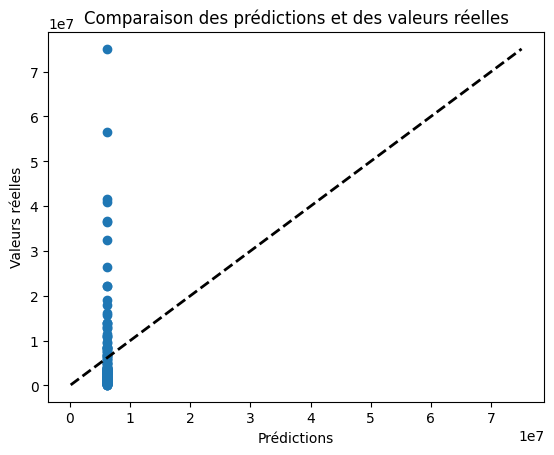

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),dummy_regr,0.000,-0.001,6170043.837,113128824873049.297,0.038681,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."


In [50]:
metrics_df_nrg, y_pred_dummy = evaluate_prediction(label_1,X_nrg_test, y_nrg_test, metrics_df_nrg, grid_dummy_nrg,X_nrg_train, y_nrg_train)

### Linear Regression

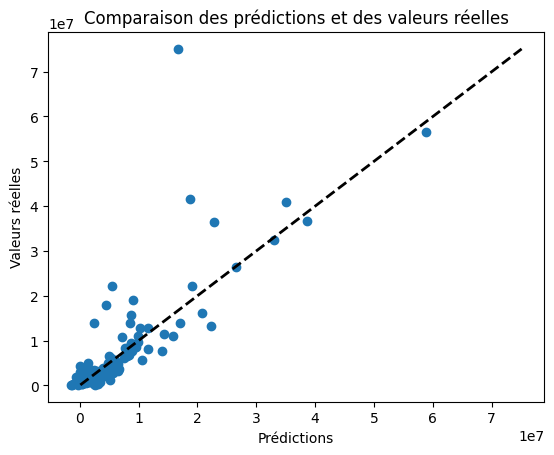

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),dummy_regr,0.000,-0.001,6170043.837,113128824873049.297,0.038681,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,SiteEnergyUse(kBtu),reg,0.825,0.662,2508607.516,38195055748200.203,0.033040,"{'reg__fit_intercept': True, 'scaler': MinMaxS..."


In [51]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

parameters = {'reg__fit_intercept': [True, False],
            "scaler": [scaler for _, scaler in scalers]}

grid_reglin_nrg = GridSearchCV(pipeline,
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_reglin_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_reg = evaluate_prediction(label_1, X_nrg_test, y_nrg_test, metrics_df_nrg, grid_reglin_nrg,X_nrg_train, y_nrg_train)

### Lasso Regression

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e+14, tolerance: 5.490e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+14, tolerance: 6.029e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

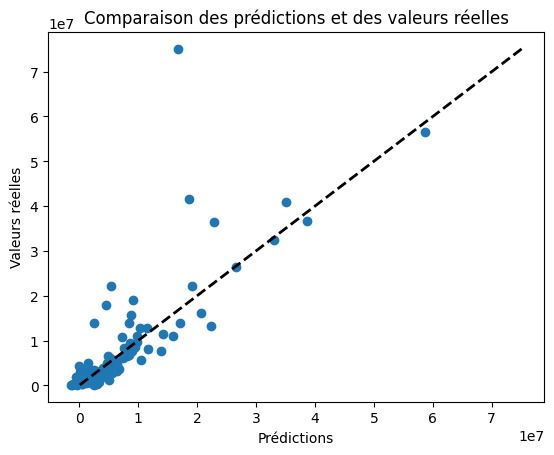

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),dummy_regr,0.000,-0.001,6170043.837,113128824873049.297,0.038681,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,SiteEnergyUse(kBtu),reg,0.825,0.662,2508607.516,38195055748200.203,0.033040,"{'reg__fit_intercept': True, 'scaler': MinMaxS..."
2,SiteEnergyUse(kBtu),lasso,0.825,0.662,2506311.340,38209162682748.633,0.053962,"{'lasso__alpha': 100.0, 'scaler': MinMaxScaler()}"


In [52]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

# Checking for alpha from .0001 to 1 and finding the best value for alpha
alpha_space = np.logspace(-4, 2, 15)

# Set the parameters  
parameters = {"lasso__alpha" : alpha_space,
            "scaler": [scaler for _, scaler in scalers]}

grid_lasso_nrg = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lasso_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_lasso = evaluate_prediction(label_1, X_nrg_test, y_nrg_test, metrics_df_nrg, grid_lasso_nrg, X_nrg_train, y_nrg_train)

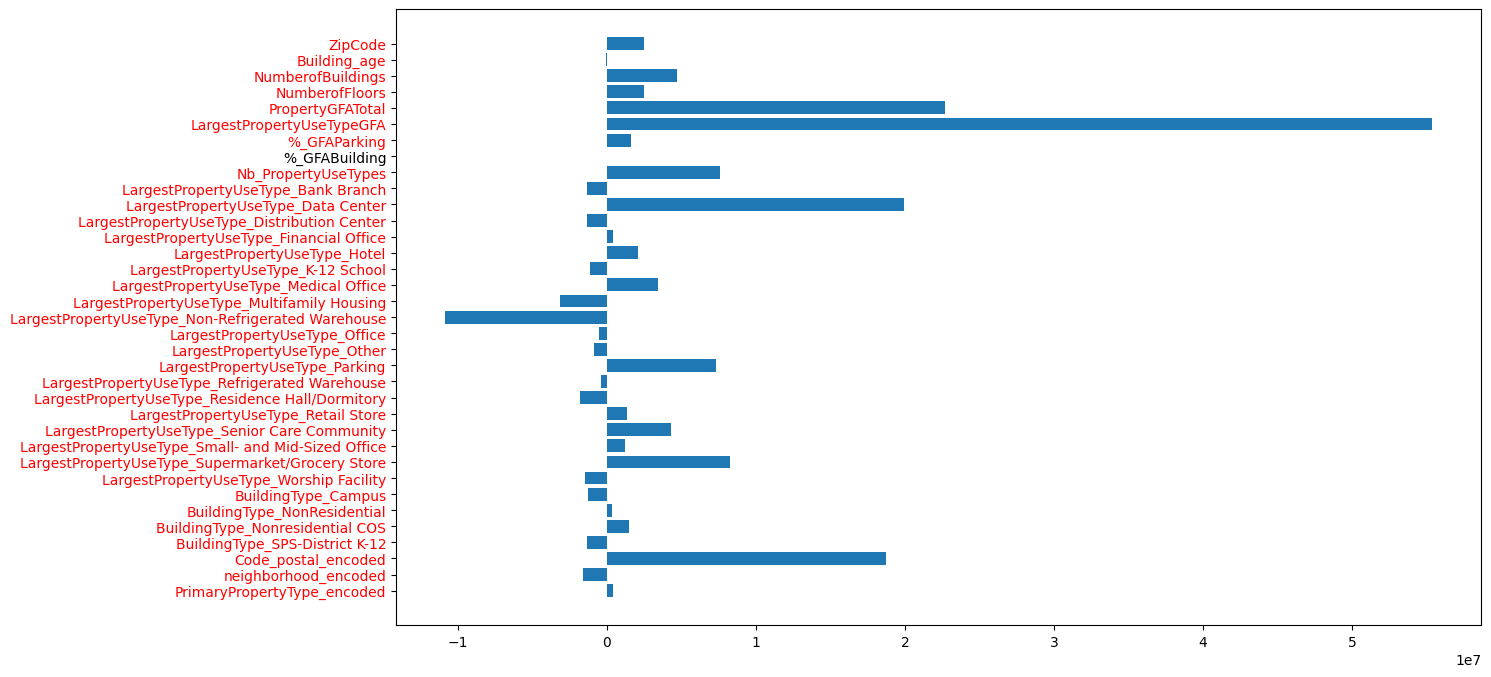

In [53]:
show_fetures_coef(grid_lasso_nrg, columns_enrg)

### Ridge regression

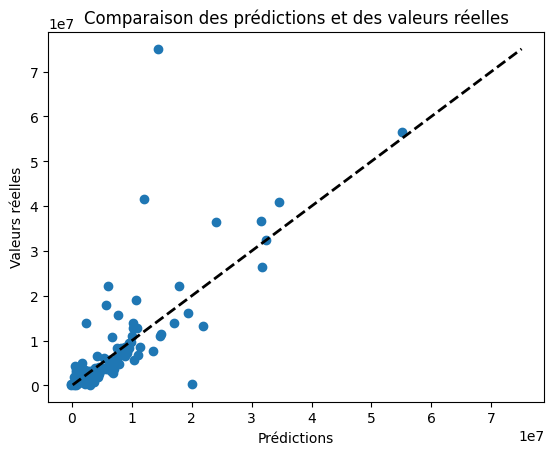

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),dummy_regr,0.000,-0.001,6170043.837,113128824873049.297,0.038681,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,SiteEnergyUse(kBtu),reg,0.825,0.662,2508607.516,38195055748200.203,0.033040,"{'reg__fit_intercept': True, 'scaler': MinMaxS..."
2,SiteEnergyUse(kBtu),lasso,0.825,0.662,2506311.340,38209162682748.633,0.053962,"{'lasso__alpha': 100.0, 'scaler': MinMaxScaler()}"
3,SiteEnergyUse(kBtu),ridge,0.811,0.603,2704448.949,44889996277318.773,0.022541,"{'ridge__alpha': 1.389495494373136, 'scaler': ..."


In [54]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

# Checking for alpha from .0001 to 1 and finding the best value for alpha
alpha_space = np.logspace(-5, 3, 15)

# Set the parameters
parameters = {"ridge__alpha" : alpha_space,
            "scaler": [scaler for _, scaler in scalers]}

grid_ridge_nrg = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_ridge_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_ridge = evaluate_prediction(label_1,X_nrg_test, y_nrg_test, metrics_df_nrg, grid_ridge_nrg, X_nrg_train, y_nrg_train)

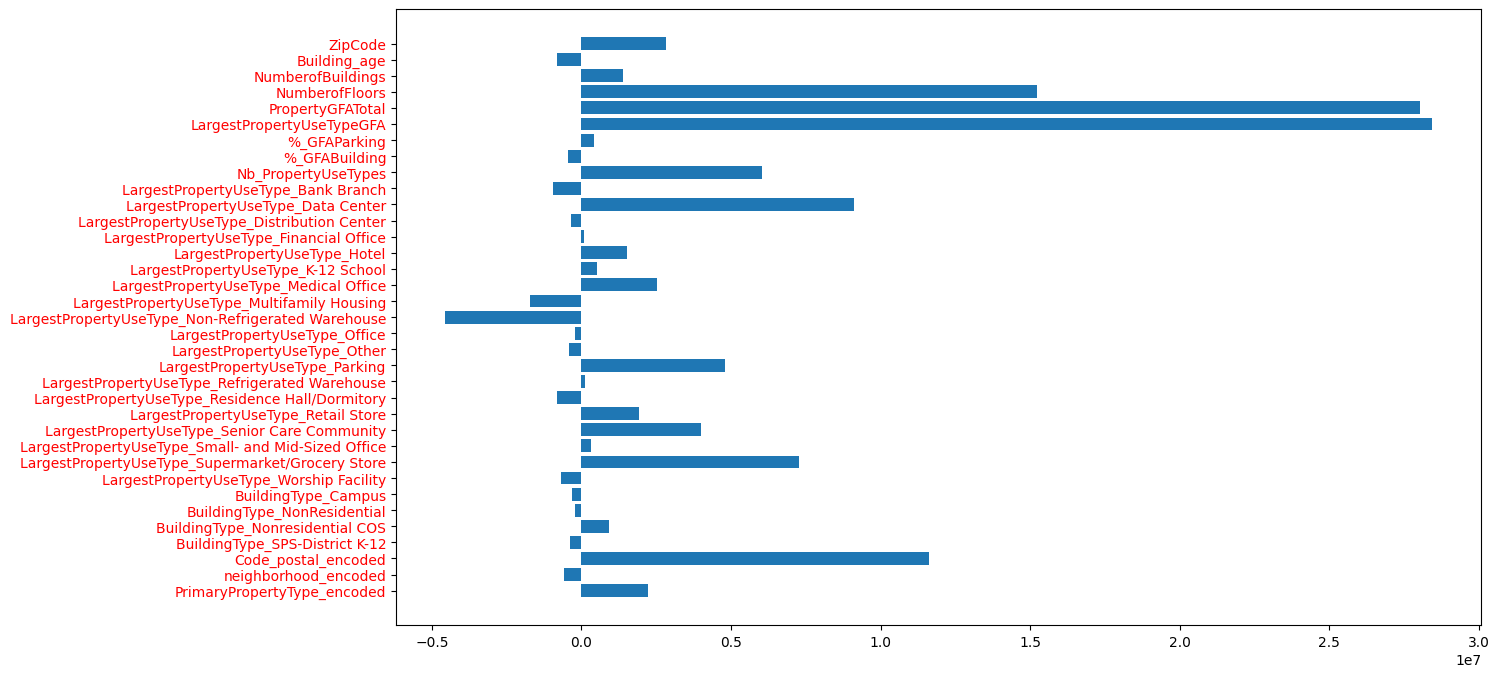

In [55]:
show_fetures_coef(grid_ridge_nrg, columns_enrg)

### Elastic Net

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.725e+15, tolerance: 5.710e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.067e+15, tolerance: 5.490e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

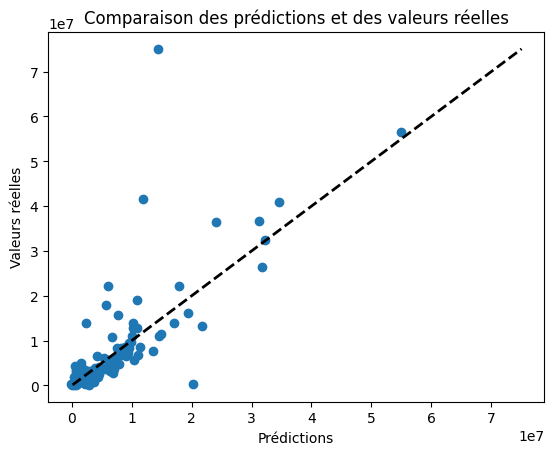

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),dummy_regr,0.000,-0.001,6170043.837,113128824873049.297,0.038681,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,SiteEnergyUse(kBtu),reg,0.825,0.662,2508607.516,38195055748200.203,0.033040,"{'reg__fit_intercept': True, 'scaler': MinMaxS..."
2,SiteEnergyUse(kBtu),lasso,0.825,0.662,2506311.340,38209162682748.633,0.053962,"{'lasso__alpha': 100.0, 'scaler': MinMaxScaler()}"
3,SiteEnergyUse(kBtu),ridge,0.811,0.603,2704448.949,44889996277318.773,0.022541,"{'ridge__alpha': 1.389495494373136, 'scaler': ..."
4,SiteEnergyUse(kBtu),elnet,0.810,0.601,2712492.944,45087903893059.039,0.142172,"{'elnet__alpha': 0.0019306977288832496, 'elnet..."


In [56]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elnet', ElasticNet(max_iter=20000,random_state=42))
])

# Checking for alpha and l1-ratio from .0001 to 1 and finding the best value for alpha
alpha_space = np.logspace(-5, 3, 15)   
l1_space = np.logspace(-3, 0, 15)

# Set the parameters
parameters = {"elnet__alpha" : alpha_space,
            "elnet__l1_ratio" : l1_space,
            "scaler" : [scaler for _, scaler in scalers]}

grid_elnet_nrg = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_elnet_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_elnet = evaluate_prediction(label_1, X_nrg_test, y_nrg_test, metrics_df_nrg, grid_elnet_nrg, X_nrg_train, y_nrg_train)

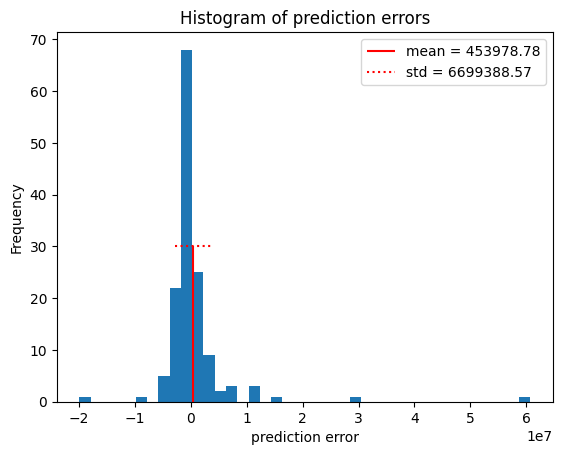

In [57]:
hist_errors(y_nrg_test, y_pred_elnet)

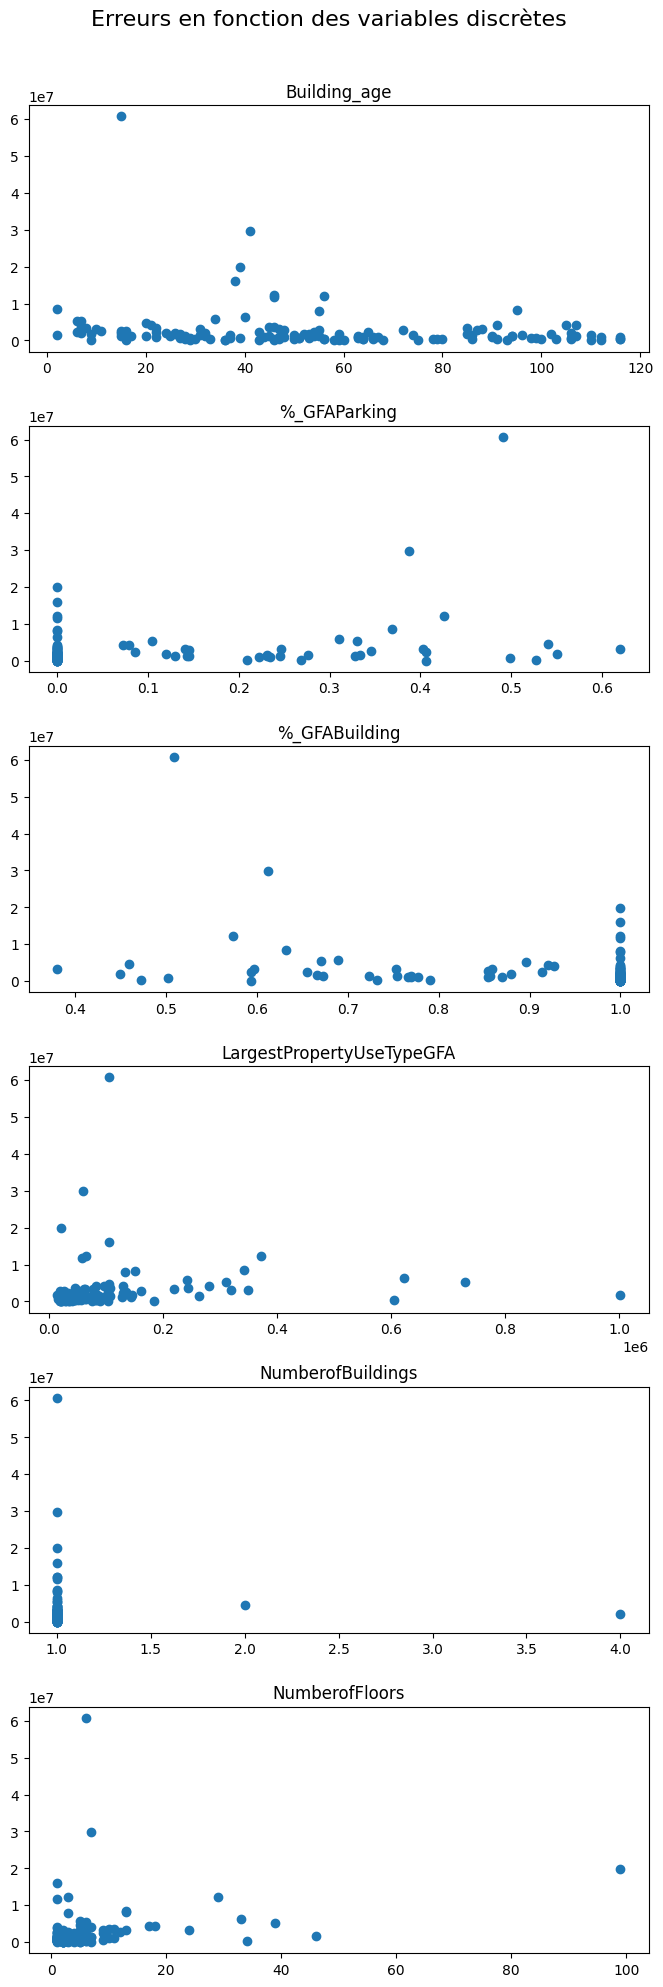

In [58]:
error_all_discr_category(df_nrg_selection, y_nrg_test, y_pred_elnet, disc_col_viz)

/var/folders/t8/clhcfp2n5sgcs4b81syf8xym0000gp/T/ipykernel_3247/3821760832.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_grouped.index, rotation=45, fontsize=7)


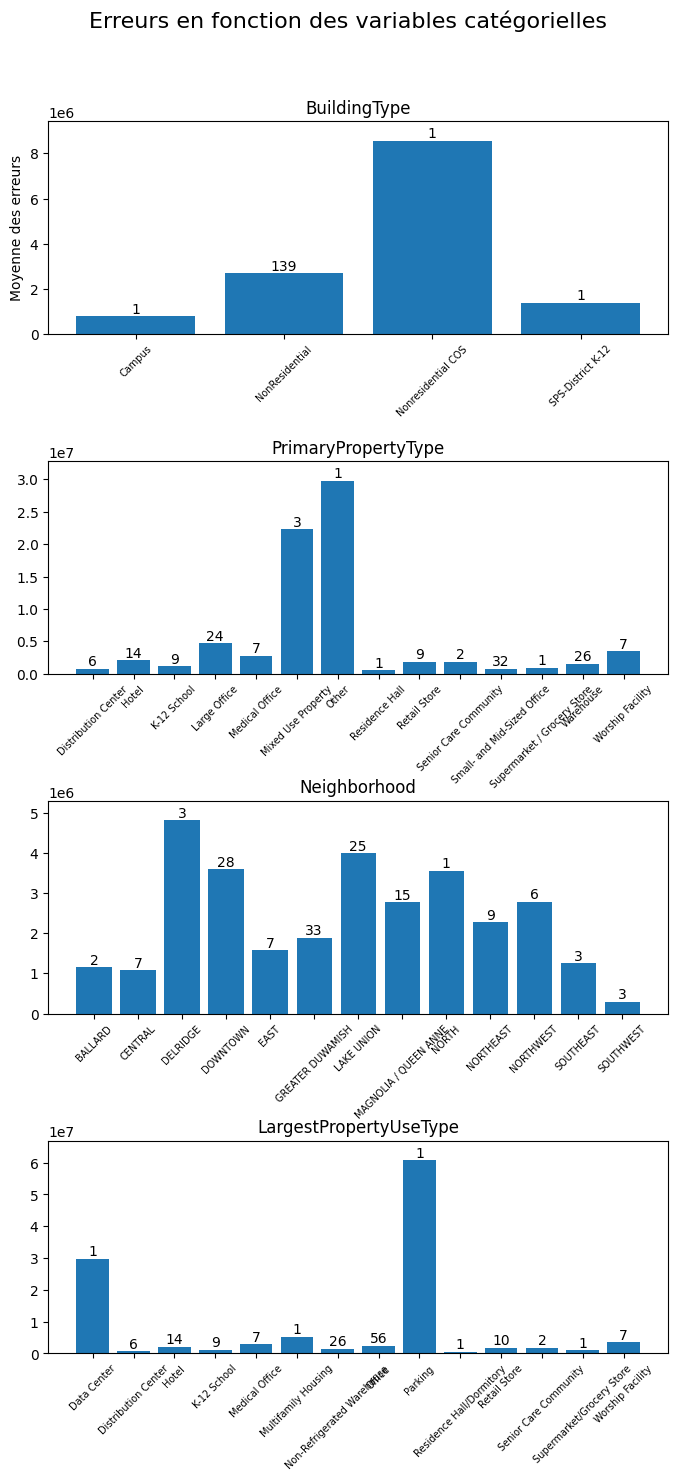

In [59]:
error_all_category(df_nrg_selection, y_nrg_test, y_pred_elnet, cat_features_next)

/var/folders/t8/clhcfp2n5sgcs4b81syf8xym0000gp/T/ipykernel_3247/2828427138.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_grouped.index, rotation=45, fontsize=7)


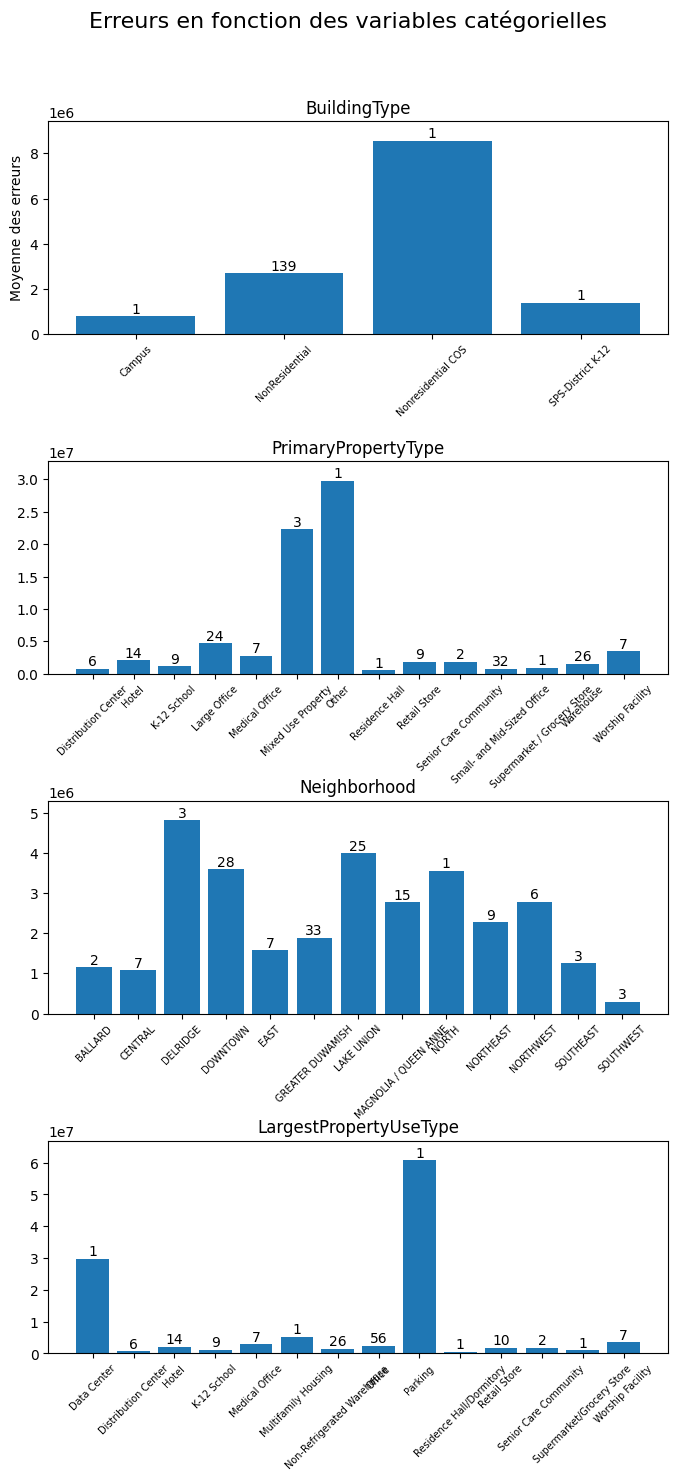

In [60]:
# Créer une figure avec des subplots
fig, axs = plt.subplots(nrows=len(cat_features_next), ncols=1, figsize=(8, 4 * len(cat_features_next)), gridspec_kw={'hspace': 0.6})
axs[0].set_ylabel('Moyenne des erreurs')

# Boucle sur les features
for i, feature in enumerate(cat_features_next):
    # Récupérer l'axe courant
    ax = axs[i]

    # Calculer les erreurs moyennes pour chaque catégorie
    df_nrg_selection["error_pred"] = abs((np.array(y_nrg_test).reshape(-1,) - y_pred_elnet))
    df_grouped = df_nrg_selection.groupby(feature).mean()['error_pred']
    counts = df_nrg_selection[feature].value_counts()

    # Afficher les barres de la moyenne des erreurs
    ax.bar(df_grouped.index, df_grouped.values)

    # Ajouter le nombre d'occurrences sur les barres de la moyenne des erreurs
    for i, v in enumerate(df_grouped.values):
        ax.text(i, v, str(counts[df_grouped.index[i]]), ha='center', va='bottom')

    # Ajouter un titre pour chaque subplot
    ax.set_title(feature)

    # Ajouter un espace supplémentaire de 10% au-dessus et en dessous des barres du graphique
    ax.margins(y=0.1)
    
    # Ajouter des étiquettes d'axe plus petites et penchées
    ax.set_xticklabels(df_grouped.index, rotation=45, fontsize=7)

# Ajouter un titre pour le graphique global
fig.suptitle('Erreurs en fonction des variables catégorielles', y=0.95, fontsize=16)

# Afficher le graphique
plt.show()


### Decision tree Regressor

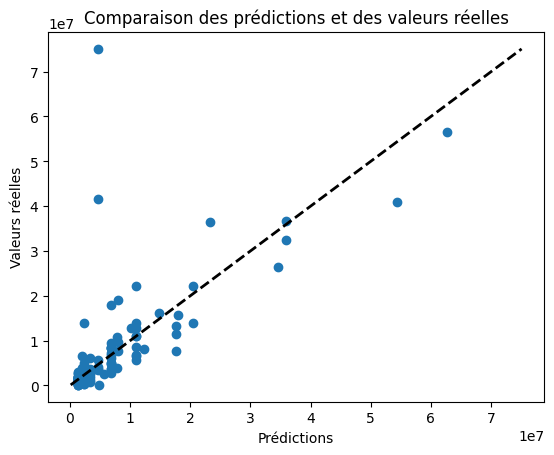

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),dummy_regr,0.000,-0.001,6170043.837,113128824873049.297,0.038681,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,SiteEnergyUse(kBtu),reg,0.825,0.662,2508607.516,38195055748200.203,0.033040,"{'reg__fit_intercept': True, 'scaler': MinMaxS..."
2,SiteEnergyUse(kBtu),lasso,0.825,0.662,2506311.340,38209162682748.633,0.053962,"{'lasso__alpha': 100.0, 'scaler': MinMaxScaler()}"
3,SiteEnergyUse(kBtu),ridge,0.811,0.603,2704448.949,44889996277318.773,0.022541,"{'ridge__alpha': 1.389495494373136, 'scaler': ..."
4,SiteEnergyUse(kBtu),elnet,0.810,0.601,2712492.944,45087903893059.039,0.142172,"{'elnet__alpha': 0.0019306977288832496, 'elnet..."
5,SiteEnergyUse(kBtu),dectree,0.851,0.510,2688717.428,55399192796502.391,0.020347,"{'dectree__max_depth': 5, 'dectree__min_sample..."


In [61]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dectree', DecisionTreeRegressor(random_state=42))
])
parameters = {'dectree__min_samples_leaf': [1, 2, 3],
            'dectree__max_depth': range(5,10),
            "scaler" : [scaler for _, scaler in scalers]}

grid_dectree_nrg = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_dectree_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_dectree = evaluate_prediction(label_1,X_nrg_test, y_nrg_test, metrics_df_nrg, grid_dectree_nrg, X_nrg_train, y_nrg_train)

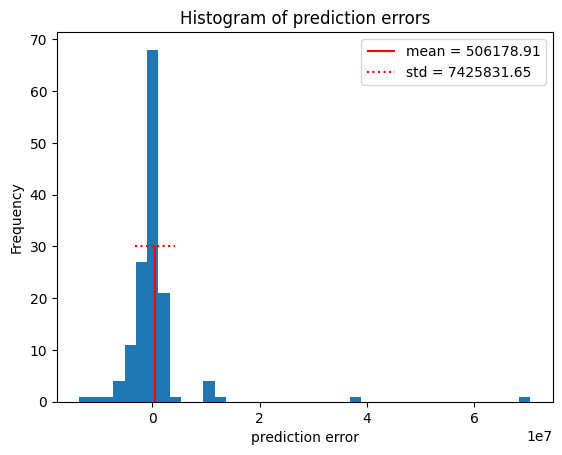

In [62]:
hist_errors(y_nrg_test, y_pred_dectree)

### RandomForestRegressor

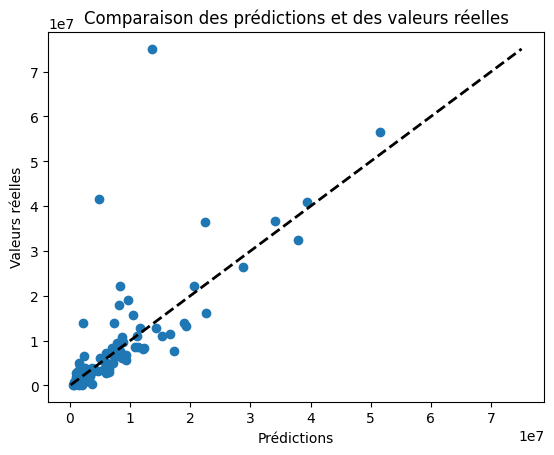

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),dummy_regr,0.000,-0.001,6170043.837,113128824873049.297,0.038681,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,SiteEnergyUse(kBtu),reg,0.825,0.662,2508607.516,38195055748200.203,0.033040,"{'reg__fit_intercept': True, 'scaler': MinMaxS..."
2,SiteEnergyUse(kBtu),lasso,0.825,0.662,2506311.340,38209162682748.633,0.053962,"{'lasso__alpha': 100.0, 'scaler': MinMaxScaler()}"
3,SiteEnergyUse(kBtu),ridge,0.811,0.603,2704448.949,44889996277318.773,0.022541,"{'ridge__alpha': 1.389495494373136, 'scaler': ..."
4,SiteEnergyUse(kBtu),elnet,0.810,0.601,2712492.944,45087903893059.039,0.142172,"{'elnet__alpha': 0.0019306977288832496, 'elnet..."
5,SiteEnergyUse(kBtu),dectree,0.851,0.510,2688717.428,55399192796502.391,0.020347,"{'dectree__max_depth': 5, 'dectree__min_sample..."
6,SiteEnergyUse(kBtu),randomforest,0.915,0.597,2460740.535,45524550505914.672,1.071241,"{'randomforest__criterion': 'absolute_error', ..."


In [63]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforest', RandomForestRegressor(random_state=42))
])

# Set the parameters
parameters = {'randomforest__min_samples_leaf': [1, 2, 3],
            'randomforest__criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
            'randomforest__max_features': [0.3,0.5,0.75,1,"sqrt","log2"],
            "scaler" : [scaler for _, scaler in scalers]}

grid_randomforest_nrg = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_randomforest_nrg.fit(X_nrg_train, y_nrg_train.values.ravel())

metrics_df_nrg, y_pred_randomforest = evaluate_prediction(label_1, X_nrg_test, y_nrg_test, metrics_df_nrg, grid_randomforest_nrg, X_nrg_train, y_nrg_train)

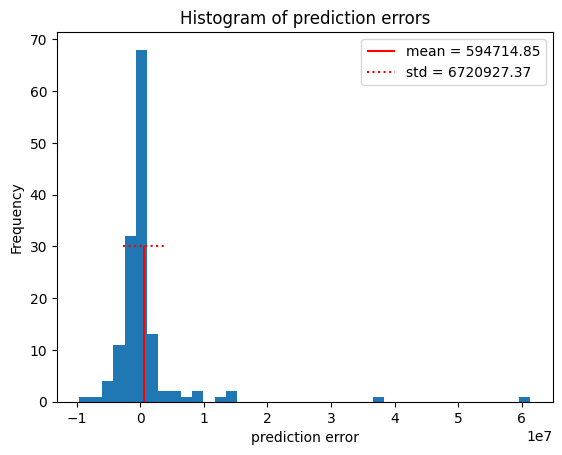

In [64]:
hist_errors(y_nrg_test, y_pred_randomforest)

### XGboost

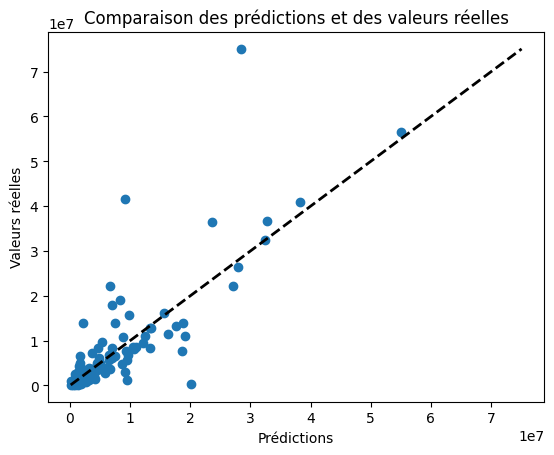

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),dummy_regr,0.000,-0.001,6170043.837,113128824873049.297,0.038681,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,SiteEnergyUse(kBtu),reg,0.825,0.662,2508607.516,38195055748200.203,0.033040,"{'reg__fit_intercept': True, 'scaler': MinMaxS..."
2,SiteEnergyUse(kBtu),lasso,0.825,0.662,2506311.340,38209162682748.633,0.053962,"{'lasso__alpha': 100.0, 'scaler': MinMaxScaler()}"
3,SiteEnergyUse(kBtu),ridge,0.811,0.603,2704448.949,44889996277318.773,0.022541,"{'ridge__alpha': 1.389495494373136, 'scaler': ..."
4,SiteEnergyUse(kBtu),elnet,0.810,0.601,2712492.944,45087903893059.039,0.142172,"{'elnet__alpha': 0.0019306977288832496, 'elnet..."
5,SiteEnergyUse(kBtu),dectree,0.851,0.510,2688717.428,55399192796502.391,0.020347,"{'dectree__max_depth': 5, 'dectree__min_sample..."
6,SiteEnergyUse(kBtu),randomforest,0.915,0.597,2460740.535,45524550505914.672,1.071241,"{'randomforest__criterion': 'absolute_error', ..."
7,SiteEnergyUse(kBtu),xgboost,0.999,0.678,2565816.275,36431063535794.617,0.461489,{'scaler': MinMaxScaler()}


In [65]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', xgboost.XGBRegressor(random_state=42))
])

# Définir les paramètres pour le GridSearchCV
parameters = {
    'scaler': [scaler for _, scaler in scalers]
}

grid_xgboost_nrg = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_xgboost_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_xgboost = evaluate_prediction(label_1, X_nrg_test, y_nrg_test, metrics_df_nrg, grid_xgboost_nrg, X_nrg_train, y_nrg_train)

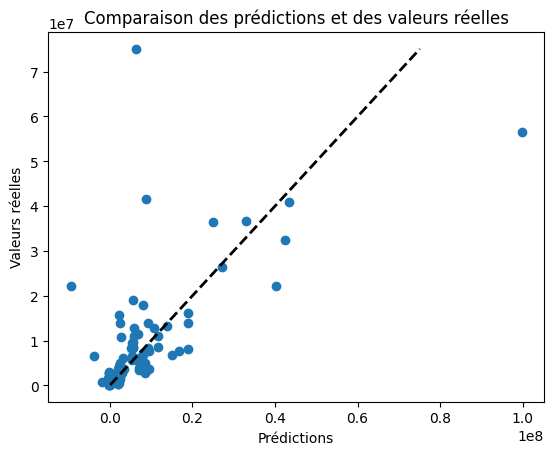

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),dummy_regr,0.000,-0.001,6170043.837,113128824873049.297,0.038681,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,SiteEnergyUse(kBtu),reg,0.825,0.662,2508607.516,38195055748200.203,0.033040,"{'reg__fit_intercept': True, 'scaler': MinMaxS..."
2,SiteEnergyUse(kBtu),lasso,0.825,0.662,2506311.340,38209162682748.633,0.053962,"{'lasso__alpha': 100.0, 'scaler': MinMaxScaler()}"
3,SiteEnergyUse(kBtu),ridge,0.811,0.603,2704448.949,44889996277318.773,0.022541,"{'ridge__alpha': 1.389495494373136, 'scaler': ..."
4,SiteEnergyUse(kBtu),elnet,0.810,0.601,2712492.944,45087903893059.039,0.142172,"{'elnet__alpha': 0.0019306977288832496, 'elnet..."
5,SiteEnergyUse(kBtu),dectree,0.851,0.510,2688717.428,55399192796502.391,0.020347,"{'dectree__max_depth': 5, 'dectree__min_sample..."
6,SiteEnergyUse(kBtu),randomforest,0.915,0.597,2460740.535,45524550505914.672,1.071241,"{'randomforest__criterion': 'absolute_error', ..."
7,SiteEnergyUse(kBtu),xgboost,0.999,0.678,2565816.275,36431063535794.617,0.461489,{'scaler': MinMaxScaler()}
8,SiteEnergyUse(kBtu),xgboost,0.894,0.326,3593376.408,76167757008485.859,0.180424,"{'scaler': MaxAbsScaler(), 'xgboost__colsample..."


In [66]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', xgboost.XGBRegressor(random_state=42))
])

# Set the parameters
eta = np.logspace(-5, 0.3, 5)
L1_reg = np.logspace(-10, 10, 5)
L2_reg = np.logspace(-10, 10, 5)
parameters = {'xgboost__max_depth': [3,7,11],
            'xgboost__learning_rate': eta,
            'xgboost__reg_alpha': L1_reg,
            'xgboost__reg_lambda' : L2_reg,
            'xgboost__colsample_bytree' : [0.25,0.5,0.75,1],
            'scaler': [scaler for _, scaler in scalers]
            }

grid_xgboost_nrg = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_xgboost_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_xgboost = evaluate_prediction(label_1, X_nrg_test, y_nrg_test, metrics_df_nrg, grid_xgboost_nrg, X_nrg_train, y_nrg_train)

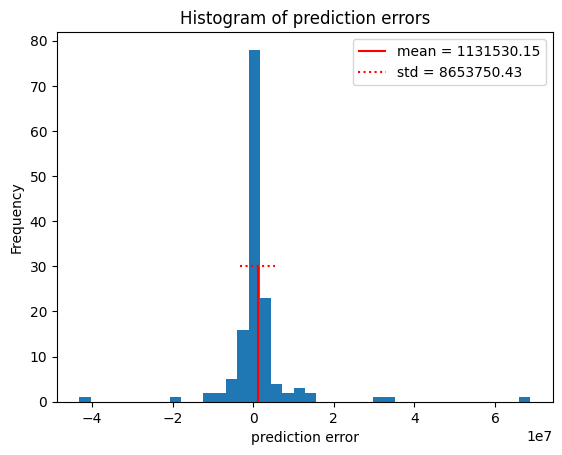

In [67]:
hist_errors(y_nrg_test, y_pred_xgboost)

### LightBoost

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/v

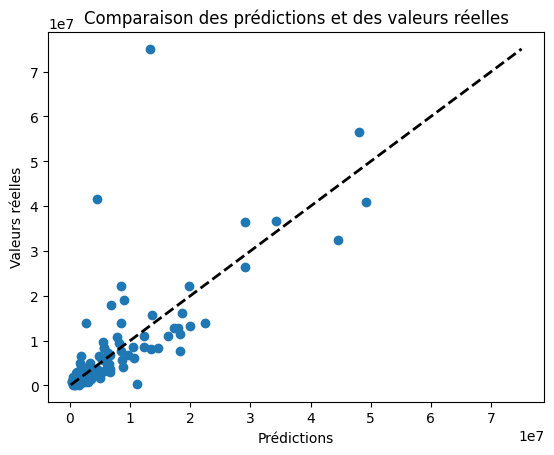

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,SiteEnergyUse(kBtu),dummy_regr,0.000,-0.001,6170043.837,113128824873049.297,0.038681,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,SiteEnergyUse(kBtu),reg,0.825,0.662,2508607.516,38195055748200.203,0.033040,"{'reg__fit_intercept': True, 'scaler': MinMaxS..."
2,SiteEnergyUse(kBtu),lasso,0.825,0.662,2506311.340,38209162682748.633,0.053962,"{'lasso__alpha': 100.0, 'scaler': MinMaxScaler()}"
3,SiteEnergyUse(kBtu),ridge,0.811,0.603,2704448.949,44889996277318.773,0.022541,"{'ridge__alpha': 1.389495494373136, 'scaler': ..."
4,SiteEnergyUse(kBtu),elnet,0.810,0.601,2712492.944,45087903893059.039,0.142172,"{'elnet__alpha': 0.0019306977288832496, 'elnet..."
5,SiteEnergyUse(kBtu),dectree,0.851,0.510,2688717.428,55399192796502.391,0.020347,"{'dectree__max_depth': 5, 'dectree__min_sample..."
6,SiteEnergyUse(kBtu),randomforest,0.915,0.597,2460740.535,45524550505914.672,1.071241,"{'randomforest__criterion': 'absolute_error', ..."
7,SiteEnergyUse(kBtu),xgboost,0.999,0.678,2565816.275,36431063535794.617,0.461489,{'scaler': MinMaxScaler()}
8,SiteEnergyUse(kBtu),xgboost,0.894,0.326,3593376.408,76167757008485.859,0.180424,"{'scaler': MaxAbsScaler(), 'xgboost__colsample..."
9,SiteEnergyUse(kBtu),lightboost,0.912,0.567,2831926.794,48991617976570.352,1.634079,"{'lightboost__learning_rate': 0.01, 'lightboos..."


In [68]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lightboost', LGBMRegressor(random_state=42))
])

# Set the parameters
parameters = {'lightboost__n_estimators': range(1000,1500,100),
            'lightboost__learning_rate': [0.01,0.001,0.03,0.1,0.3],
            'scaler': [scaler for _, scaler in scalers]}

grid_lightboost_nrg = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lightboost_nrg.fit(X_nrg_train, y_nrg_train)

metrics_df_nrg, y_pred_lgboost = evaluate_prediction(label_1,X_nrg_test, y_nrg_test, metrics_df_nrg, grid_lightboost_nrg, X_nrg_train, y_nrg_train)

## Label 2 - GHE

### Dummy Regression

In [69]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dummy_regr', DummyRegressor())
])
parameters = {"dummy_regr__strategy" : ("mean","median"),
            "scaler": [scaler for _, scaler in scalers]}

grid_dummy_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_dummy_ghe.fit(X_ghe_train, y_ghe_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dummy_regr', DummyRegressor())]),
             n_jobs=-1,
             param_grid={'dummy_regr__strategy': ('mean', 'median'),
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    MaxAbsScaler()]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

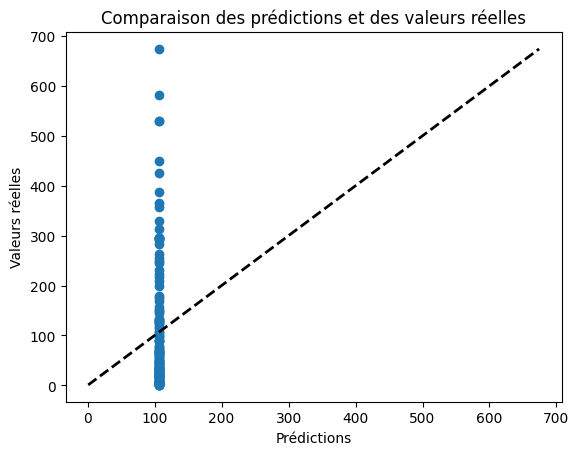

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.019006,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."


In [70]:
metrics_df_ghe, y_pred_dummy_ghe = evaluate_prediction(label_2, X_ghe_test, y_ghe_test, metrics_df_ghe, grid_dummy_ghe, X_ghe_train, y_ghe_train)

### Linear Regression

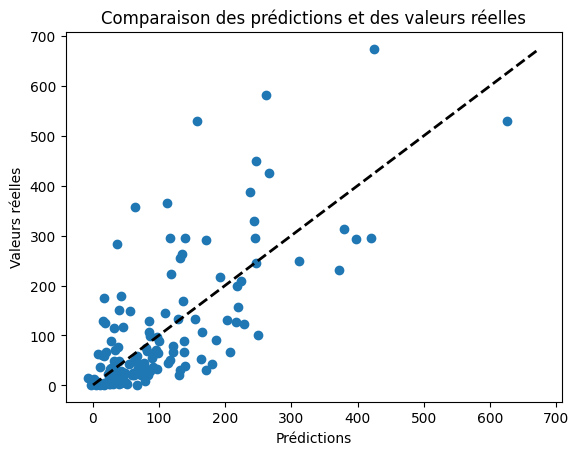

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.019006,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.453,8252.730,0.021747,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."


In [71]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

parameters = {'reg__fit_intercept': [True, False],
            "scaler": [scaler for _, scaler in scalers]}

grid_reglin_ghe = GridSearchCV(pipeline,
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_reglin_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_reg_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_reglin_ghe, X_ghe_train, y_ghe_train)

### Lasso Regression

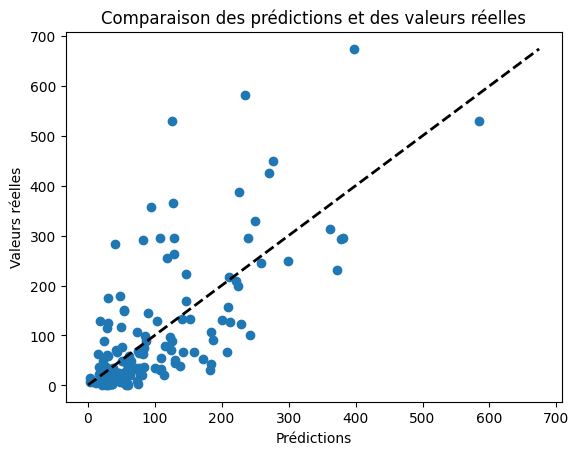

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.019006,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.453,8252.730,0.021747,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.023272,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."


In [72]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

# Checking for alpha from .0001 to 1 and finding the best value for alpha
alpha_space = np.logspace(-4, 2, 15)

# Set the parameters  
parameters = {"lasso__alpha" : alpha_space,
            "scaler": [scaler for _, scaler in scalers]}

grid_lasso_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lasso_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_lasso_ghe = evaluate_prediction(label_2, X_ghe_test, y_ghe_test, metrics_df_ghe, grid_lasso_ghe, X_ghe_train, y_ghe_train)

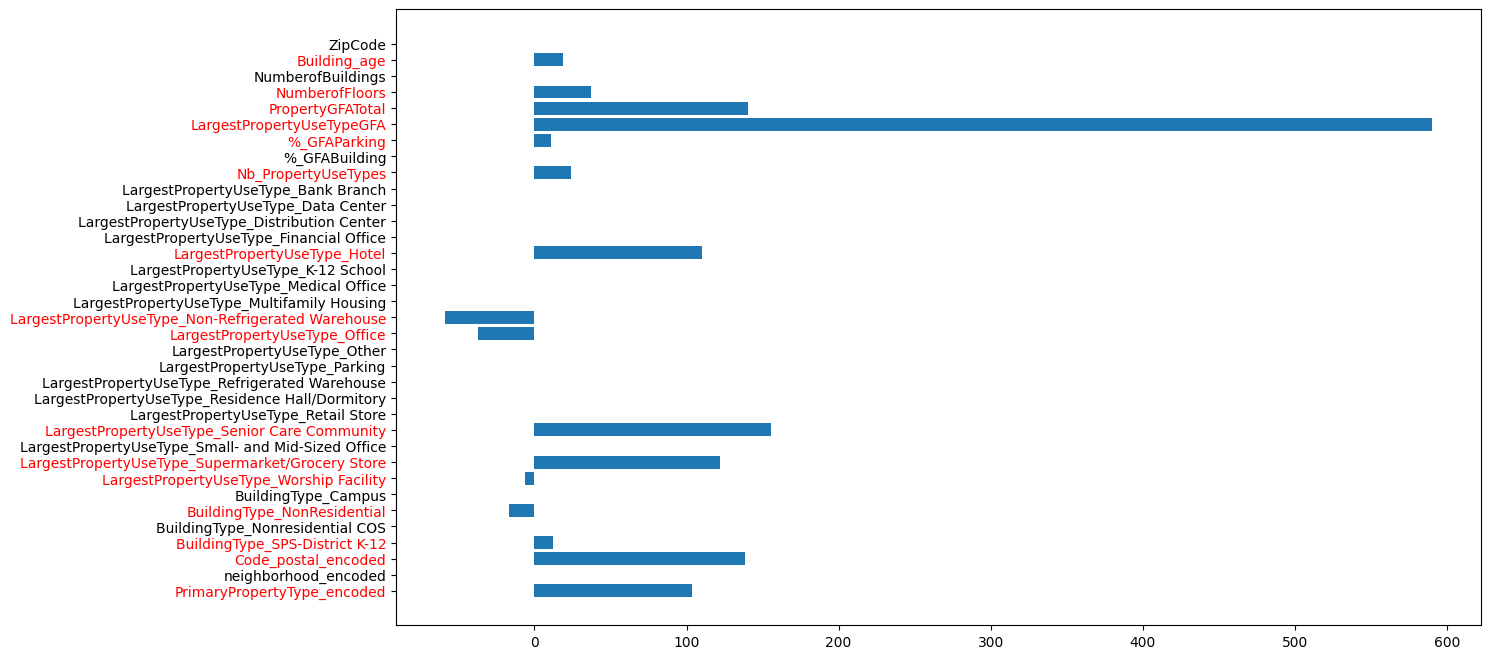

In [73]:
show_fetures_coef(grid_lasso_ghe, columns_ghe)

### Ridge 

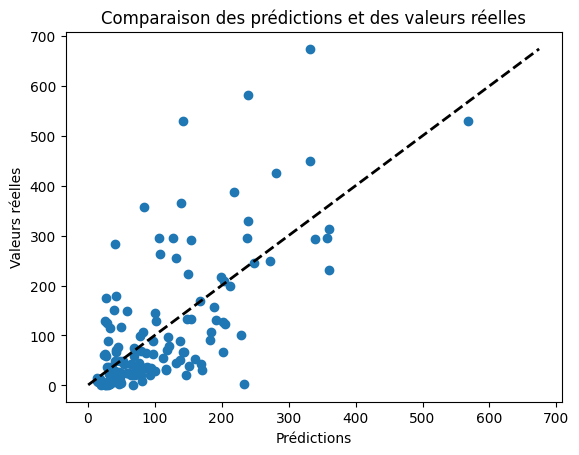

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.019006,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.453,8252.730,0.021747,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.023272,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.016795,"{'ridge__alpha': 268.26957952797216, 'scaler':..."


In [74]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

# Checking for alpha from .0001 to 1 and finding the best value for alpha
alpha_space = np.logspace(-5, 3, 15)

# Set the parameters
parameters = {"ridge__alpha" : alpha_space,
            "scaler": [scaler for _, scaler in scalers]}

grid_ridge_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_ridge_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_ridge_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_ridge_ghe, X_ghe_train, y_ghe_train)

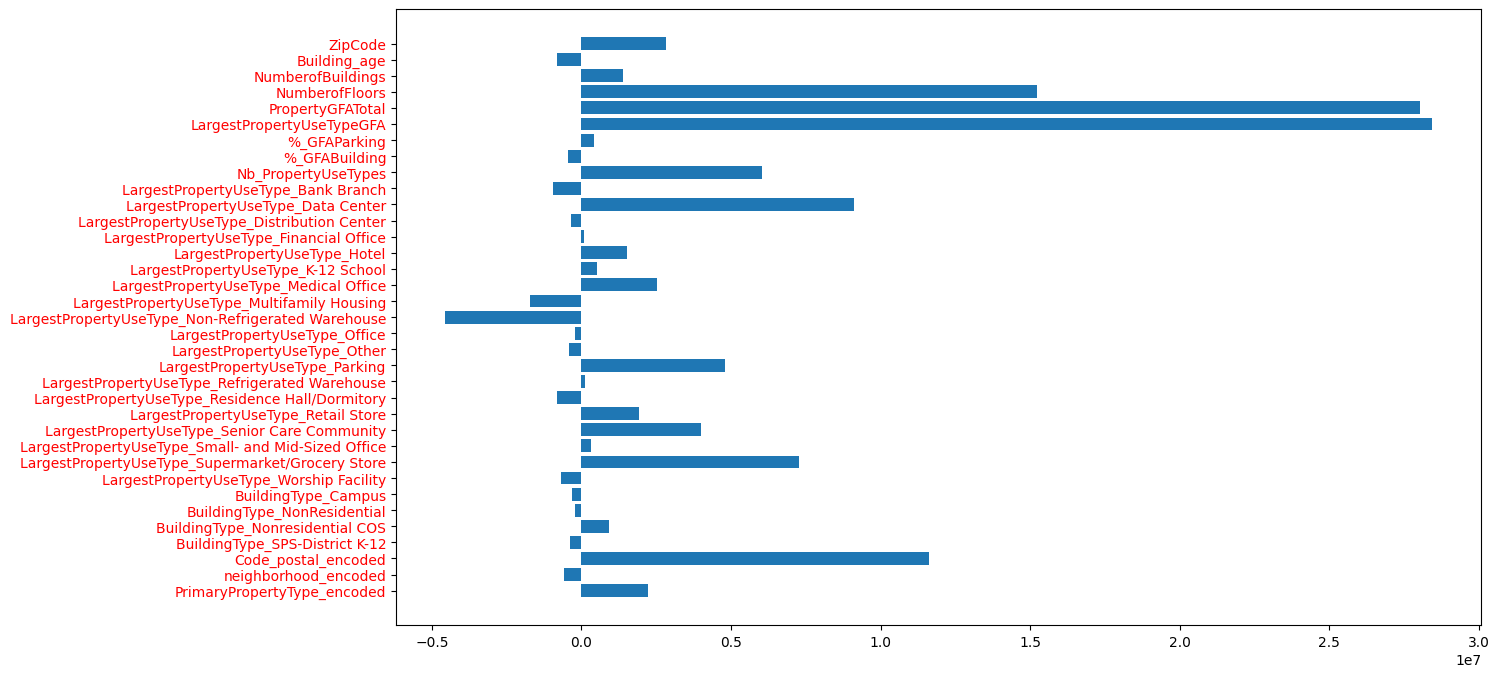

In [75]:
show_fetures_coef(grid_ridge_nrg, columns_enrg)

### Elastic Net

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e+06, tolerance: 1.411e+03
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.706e+06, tolerance: 1.584e+03
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

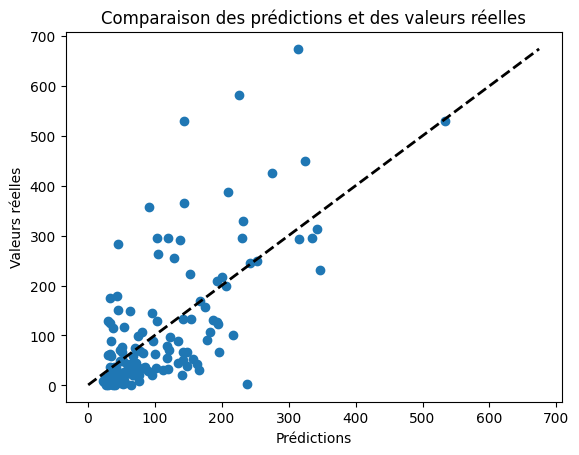

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.019006,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.453,8252.730,0.021747,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.023272,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.016795,"{'ridge__alpha': 268.26957952797216, 'scaler':..."
4,TotalGHGEmissions,elnet,0.483,0.485,63.403,8736.821,0.096082,"{'elnet__alpha': 1.389495494373136, 'elnet__l1..."


In [76]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elnet', ElasticNet(max_iter=20000,random_state=42))
])

# Checking for alpha and l1-ratio from .0001 to 1 and finding the best value for alpha
alpha_space = np.logspace(-5, 3, 15)   
l1_space = np.logspace(-3, 0, 15)

# Set the parameters
parameters = {"elnet__alpha" : alpha_space,
            "elnet__l1_ratio" : l1_space,
            "scaler" : [scaler for _, scaler in scalers]}

grid_elnet_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_elnet_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_elnet_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_elnet_ghe, X_ghe_train, y_ghe_train)

### Decision tree Regressor

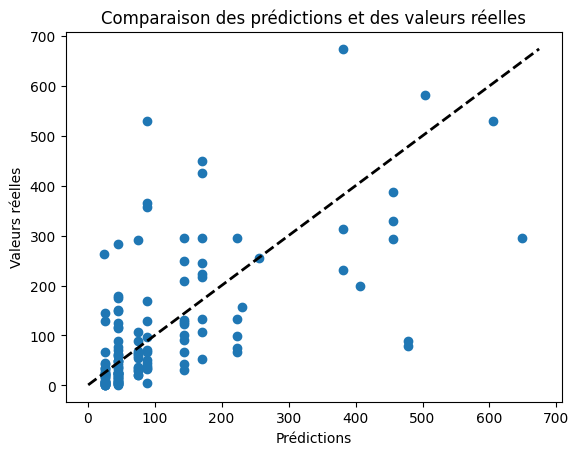

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.019006,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.453,8252.730,0.021747,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.023272,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.016795,"{'ridge__alpha': 268.26957952797216, 'scaler':..."
4,TotalGHGEmissions,elnet,0.483,0.485,63.403,8736.821,0.096082,"{'elnet__alpha': 1.389495494373136, 'elnet__l1..."
5,TotalGHGEmissions,dectree,0.708,0.304,67.919,11806.227,0.018563,"{'dectree__max_depth': 5, 'dectree__min_sample..."


In [77]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dectree', DecisionTreeRegressor(random_state=42))
])
parameters = {'dectree__min_samples_leaf': [1, 2, 3],
            'dectree__max_depth': range(5,10),
            "scaler" : [scaler for _, scaler in scalers]}

grid_dectree_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_dectree_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_dectree_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_dectree_ghe, X_ghe_train, y_ghe_train)

### RandomForest

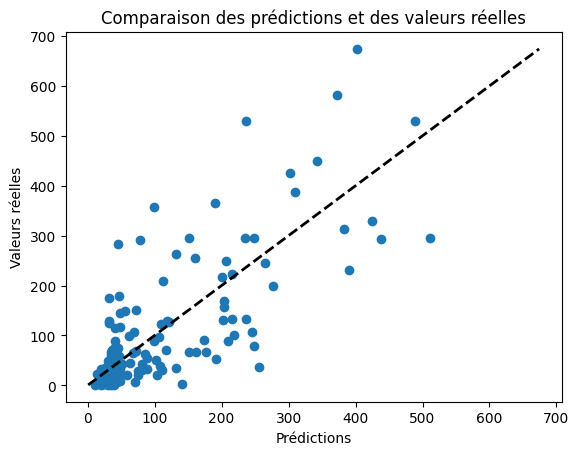

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.019006,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.453,8252.730,0.021747,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.023272,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.016795,"{'ridge__alpha': 268.26957952797216, 'scaler':..."
4,TotalGHGEmissions,elnet,0.483,0.485,63.403,8736.821,0.096082,"{'elnet__alpha': 1.389495494373136, 'elnet__l1..."
5,TotalGHGEmissions,dectree,0.708,0.304,67.919,11806.227,0.018563,"{'dectree__max_depth': 5, 'dectree__min_sample..."
6,TotalGHGEmissions,randomforest,0.925,0.578,58.116,7155.570,1.054662,"{'randomforest__criterion': 'absolute_error', ..."


In [78]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforest', RandomForestRegressor(random_state=42))
])

# Set the parameters
parameters = {'randomforest__min_samples_leaf': [1, 2, 3],
            'randomforest__criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
            'randomforest__max_features': [0.3,0.5,0.75,1,"sqrt","log2"],
            "scaler" : [scaler for _, scaler in scalers]}

grid_randomforest_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_randomforest_ghe.fit(X_ghe_train, y_ghe_train.values.ravel())

metrics_df_ghe, y_pred_forest_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_randomforest_ghe, X_ghe_train, y_ghe_train)

### XGBoost

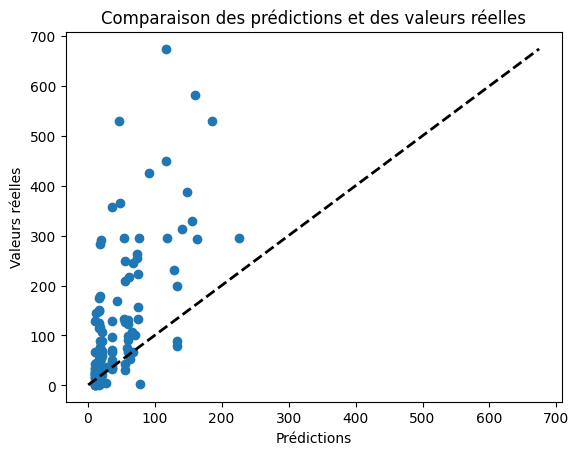

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.019006,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.453,8252.730,0.021747,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.023272,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.016795,"{'ridge__alpha': 268.26957952797216, 'scaler':..."
4,TotalGHGEmissions,elnet,0.483,0.485,63.403,8736.821,0.096082,"{'elnet__alpha': 1.389495494373136, 'elnet__l1..."
5,TotalGHGEmissions,dectree,0.708,0.304,67.919,11806.227,0.018563,"{'dectree__max_depth': 5, 'dectree__min_sample..."
6,TotalGHGEmissions,randomforest,0.925,0.578,58.116,7155.570,1.054662,"{'randomforest__criterion': 'absolute_error', ..."
7,TotalGHGEmissions,xgboost,0.220,0.091,71.897,15415.906,0.188171,"{'scaler': MaxAbsScaler(), 'xgboost__colsample..."


In [79]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', xgboost.XGBRegressor(random_state=42))
])

# Set the parameters
eta = np.logspace(-5, 0.3, 5)
L1_reg = np.logspace(-10, 10, 5)
L2_reg = np.logspace(-10, 10, 5)
parameters = {'xgboost__max_depth': [3,7,11],
            'xgboost__learning_rate': eta,
            'xgboost__reg_alpha': L1_reg,
            'xgboost__reg_lambda' : L2_reg,
            'xgboost__colsample_bytree' : [0.25,0.5,0.75,1],
            'scaler': [scaler for _, scaler in scalers]
            }

grid_xgboost_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_xgboost_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_xgboost_ghe = evaluate_prediction(label_2, X_ghe_test, y_ghe_test, metrics_df_ghe, grid_xgboost_ghe, X_ghe_train, y_ghe_train)

### LightBoost

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/v

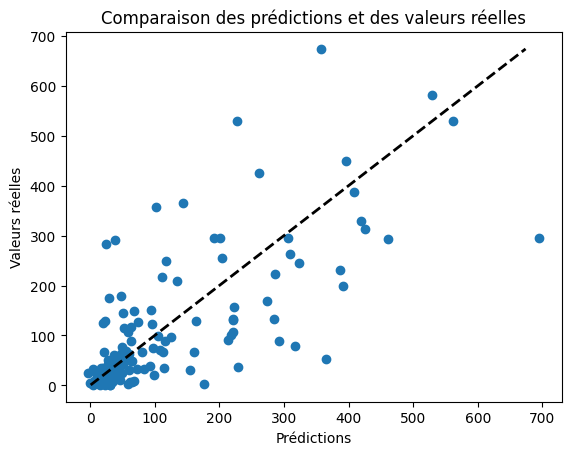

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.019006,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.453,8252.730,0.021747,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.023272,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.016795,"{'ridge__alpha': 268.26957952797216, 'scaler':..."
4,TotalGHGEmissions,elnet,0.483,0.485,63.403,8736.821,0.096082,"{'elnet__alpha': 1.389495494373136, 'elnet__l1..."
5,TotalGHGEmissions,dectree,0.708,0.304,67.919,11806.227,0.018563,"{'dectree__max_depth': 5, 'dectree__min_sample..."
6,TotalGHGEmissions,randomforest,0.925,0.578,58.116,7155.570,1.054662,"{'randomforest__criterion': 'absolute_error', ..."
7,TotalGHGEmissions,xgboost,0.220,0.091,71.897,15415.906,0.188171,"{'scaler': MaxAbsScaler(), 'xgboost__colsample..."
8,TotalGHGEmissions,lightboost,0.879,0.441,61.866,9489.108,1.824299,"{'lightboost__learning_rate': 0.01, 'lightboos..."


In [80]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lightboost', LGBMRegressor(random_state=42))
])

# Set the parameters
parameters = {'lightboost__n_estimators': range(1000,1500,100),
            'lightboost__learning_rate': [0.01,0.001,0.03,0.1,0.3],
            'scaler': [scaler for _, scaler in scalers]}

grid_lightboost_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lightboost_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_lgboost_ghe = evaluate_prediction(label_2, X_ghe_test, y_ghe_test, metrics_df_ghe, grid_lightboost_ghe, X_ghe_train, y_ghe_train)

# Feature importance du meilleur modèle

## Random Forest pour le label_1

/var/folders/t8/clhcfp2n5sgcs4b81syf8xym0000gp/T/ipykernel_3247/1176137019.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random.fit(X_nrg_train_scaled, y_nrg_train)


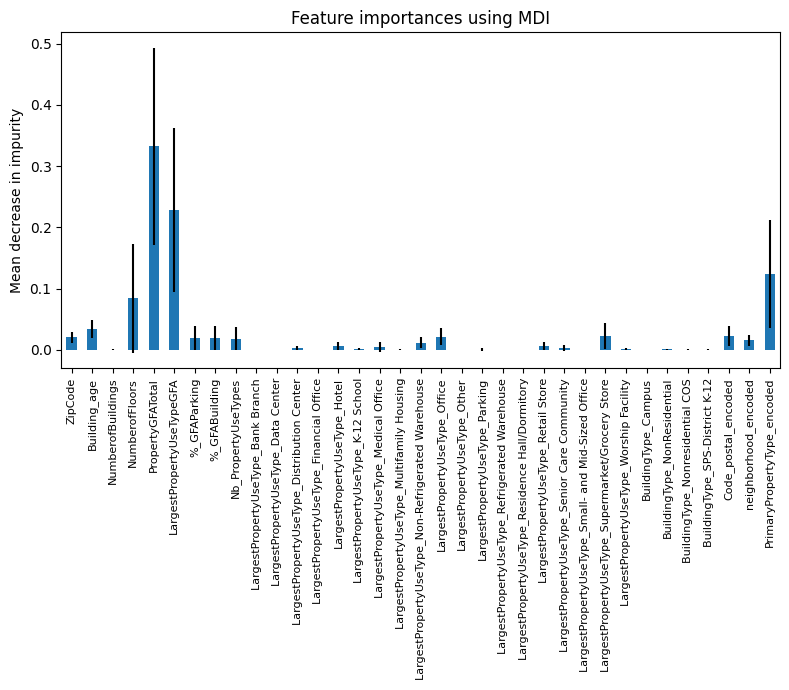

In [81]:
random_params = grid_randomforest_nrg.best_params_

scaler = random_params['scaler']
    
X_nrg_train_scaled = scaler.fit_transform(X_nrg_train)

random = RandomForestRegressor(random_state=42,
                            criterion = random_params['randomforest__criterion'],
                            max_features = random_params['randomforest__max_features'],
                            min_samples_leaf = random_params['randomforest__min_samples_leaf'])

random.fit(X_nrg_train_scaled, y_nrg_train)
importances = random.feature_importances_

forest_importances = pd.Series(importances, index=X_nrg_train.columns)

std = np.std([tree.feature_importances_ for tree in random.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(8,7))
forest_importances.plot.bar(yerr=std, ax=ax)

# Ajuster la taille des étiquettes de l'axe des abscisses
ax.tick_params(axis='x', labelsize=8)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [84]:
boost_params

{'scaler': MaxAbsScaler(),
 'xgboost__colsample_bytree': 1,
 'xgboost__learning_rate': 0.0044668359215096305,
 'xgboost__max_depth': 5,
 'xgboost__reg_alpha': 1e-10,
 'xgboost__reg_lambda': 1e-10}

In [88]:
grid_xgboost_ghe.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
from sklearn.feature_selection import SelectFromModel

boost_params = grid_xgboost_ghe.best_params_

In [95]:
scaler = boost_params['scaler']
xgboost_model = xgboost.XGBRegressor(random_state=42,
                                    max_depth = boost_params["xgboost__max_depth"],
                                    learning_rate = boost_params["xgboost__learning_rate"],
                                    reg_alpha = boost_params["xgboost__reg_alpha"],
                                    reg_lambda = boost_params["xgboost__reg_lambda"],
                                    colsample_bytree = boost_params["xgboost__colsample_bytree"])
grid_xgboost_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
X_ghe_train_scaled = scaler.fit_transform(X_ghe_train)
X_ghe_test_scaled = scaler.transform(X_ghe_test)
xgboost_model.fit(X_ghe_train_scaled, y_ghe_train)

# Fit model using each importance as a threshold
thresholds = np.sort(xgboost_model.feature_importances_)

for thresh in thresholds[15:]:
    # select features using threshold
    selection = SelectFromModel(xgboost_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_ghe_train_scaled)
    # train model
    selection_model = xgboost.XGBRegressor(random_state=42,
                                    max_depth = boost_params["xgboost__max_depth"],
                                    learning_rate = boost_params["xgboost__learning_rate"],
                                    reg_alpha = boost_params["xgboost__reg_alpha"],
                                    reg_lambda = boost_params["xgboost__reg_lambda"],
                                    colsample_bytree = boost_params["xgboost__colsample_bytree"])
    selection_model.fit(select_X_train, y_ghe_train)
    # eval model
    select_X_test = selection.transform(X_ghe_test_scaled)
    predictions = selection_model.predict(select_X_test)
    r2 = r2_score(y_ghe_test, predictions)
    print("Thresh=%.3f, n=%d, r2: %.2f%%" % (thresh, select_X_train.shape[1], r2))


Thresh=0.005, n=20, r2: 9.11%
Thresh=0.007, n=19, r2: 9.28%
Thresh=0.008, n=18, r2: 9.28%
Thresh=0.010, n=17, r2: 9.28%
Thresh=0.012, n=16, r2: 9.07%
Thresh=0.016, n=15, r2: 9.07%
Thresh=0.020, n=14, r2: 9.59%
Thresh=0.021, n=13, r2: 12.87%
Thresh=0.029, n=12, r2: 13.11%
Thresh=0.031, n=11, r2: 12.32%
Thresh=0.036, n=10, r2: 12.32%
Thresh=0.038, n=9, r2: 12.10%
Thresh=0.044, n=8, r2: 10.64%
Thresh=0.047, n=7, r2: 10.28%
Thresh=0.055, n=6, r2: 10.90%
Thresh=0.073, n=5, r2: 6.95%
Thresh=0.079, n=4, r2: 6.69%
Thresh=0.093, n=3, r2: 5.37%
Thresh=0.162, n=2, r2: 5.75%
Thresh=0.216, n=1, r2: -10.87%


# Test l'importance de l'energy star score

In [103]:
features_star = ['BuildingType', 'PrimaryPropertyType', 'ZipCode',
    'Neighborhood',  'Building_age','NumberofBuildings',
    'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA',  '%_LargestPropertyUseType','SourceEUI(kBtu/sf)',
    'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)',
    'TotalGHGEmissions', "ENERGYSTARScore",
    '%_GFAParking', '%_GFABuilding','Nb_PropertyUseTypes']

df_star = data[features_star]

X_star = pipe_ohe(df_star)
y1 = df[[label_1]]
y2 = df[[label_2]]

X_enrg_train_star, X_enrg_test_star, y_nrg_train_star, y_nrg_test_star = train_test_split(X_star,y1,test_size=0.15, random_state=42, stratify=df["BuildingType"])
print(X_enrg_train_star.shape, X_enrg_test_star.shape)

# séparer la donnée pour avoir les 
X_ghge_train_star, X_ghge_test_star, y_ghe_train_star, y_ghe_test_star = train_test_split(X_star,y2,test_size=0.15, random_state=42, stratify=df["BuildingType"])
print(X_ghge_train_star.shape, X_ghge_test_star.shape)

X_nrg_train_star, means_zipcode_enrg, means_neighborhood_enrg, means_ppropertype_enrg, columns_enrg = pipe(X_enrg_train_star,col_for_mean=label_1)
X_nrg_test_star, means_zipcode_enrg, means_neighborhood_enrg, means_ppropertype_enrg, a = pipe(X_enrg_test_star,
                                                                        means_zipcode=means_zipcode_enrg,
                                                                        means_neighborhood=means_neighborhood_enrg,
                                                                        means_ppropertype=means_ppropertype_enrg,
                                                                        col_for_mean=label_1)

X_ghe_train_star, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, columns_ghe = pipe(X_ghge_train_star,col_for_mean=label_2)
X_ghe_test_star, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, b = pipe(X_ghge_test_star, 
                                                                        means_zipcode=means_zipcode_ghe,
                                                                        means_neighborhood=means_neighborhood_ghe,
                                                                        means_ppropertype=means_ppropertype_ghe,
                                                                        col_for_mean=label_2)

(800, 41) (142, 41)
(800, 41) (142, 41)


In [105]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforest_star', RandomForestRegressor(random_state=42))
])

# Set the parameters
parameters = {'randomforest_star__min_samples_leaf': [1, 2, 3],
            'randomforest_star__criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
            'randomforest_star__max_features': [0.3,0.5,0.75,1,"sqrt","log2"],
            "scaler" : [scaler for _, scaler in scalers]}

grid_randomforest_nrg = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_randomforest_nrg.fit(X_nrg_train_star, y_nrg_train_star.values.ravel())

metrics_df_nrg, y_pred_randomforest = evaluate_prediction(label_1, X_nrg_test_star, y_nrg_test_star, metrics_df_nrg, grid_randomforest_nrg, X_nrg_train, y_nrg_train)

In [ ]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost_star', xgboost.XGBRegressor(random_state=42))
])

# Set the parameters
eta = np.logspace(-5, 0.3, 3)
L1_reg = np.logspace(-10, 10, 3)
L2_reg = np.logspace(-10, 10, 3)
parameters = {'xgboost_star__max_depth': [2,3,5],
            'xgboost_star__learning_rate': eta,
            'xgboost_star__reg_alpha': L1_reg,
            'xgboost_star__reg_lambda' : L2_reg,
            'xgboost_star__colsample_bytree' : [0.5,0.75,1],
            'scaler': [scaler for _, scaler in scalers]
            }

grid_xgboost_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_xgboost_ghe.fit(X_ghe_train_star, y_ghe_train_star)

metrics_df_ghe, y_pred_xgboost_ghe = evaluate_prediction(label_2, X_ghe_test_star, y_ghe_test_star, metrics_df_ghe, grid_xgboost_ghe, X_ghe_train, y_ghe_train)